# Parameters from symbols to input fields 

Model development follows the general work flow

**Phase I: Jupyter development phase**
1. Derive the model equations, use sympy to rapidly prototype algebraic, differential and integral formulas involved in the model
2. Transform the important expressions to executable python functions using `sp.lambdify` with `numpy` interface to evaluate derived formulas on arrays
3. Test the and demonstrate the correctness of the expressions using visualization `matplotlib` singular plots. Even better, provide an interaction interfaces using `ipywidgets`. 

**Phase II: Python packaging phase**
4. Define a class diagram reflecting the physical nature of the problem with objects (Beam, Materialmodel, Reinforcementbar).
5. Associate the executable functions derived in the Phase I with the class as methods or as properties
6. Provide an application programming interface

**Phase III: Jupyter examples/studies/webapp**
6. Import the designed Python package into the a Jupyter notebooks, explain and demonstrate the features of the package. 
7. Design a jupyter interface using `ipywidgets` showing the functionality of an implemented package in an interactive way
8. Provide one or more Jupyter notebooks as webapps on `github` that can be executed using the `binder` service. 
9. Use `zenodo` to produce a doi to enable package citations in papers. 

@TODO - installation on pypi - 
`pip install bmcs_beam`

## Sympy model definition

In [25]:
%matplotlib notebook

In [26]:
%%html
<style>
.output_wrapper button.btn.btn-default,
.output_wrapper .ui-dialog-titlebar {
  display: none;
}
</style>

In [27]:
import sympy as sp
sp.init_printing()

Let us construct a model calculating extreme values a quadratic function
\begin{align}
y = ax^2 + bx + c
\end{align}
This function represents our model

In [28]:
a, b, c, zeta = sp.symbols(r'a,b,c,\zeta_\mathrm{roman}')
x = sp.Symbol('x')

In [29]:
y_ = a * x**2 + b * x + c + zeta*x
y_

In [30]:
y_dx_ = y_.diff(x)
y_dx_

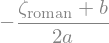

In [31]:
x_argmax_ = sp.solve(y_dx_, x)[0]
x_argmax_

In [32]:
param_names = ('a', 'b', 'c', 'zeta')
get_params = lambda param_names, **kw: tuple(kw[name] for name in param_names)
sp_params = tuple(globals()[name] for name in param_names)
sp_params

## Lambdify the symbolic functions

In [33]:
get_x_argmax = sp.lambdify(sp_params, x_argmax_, 'numpy', dummify=True)
get_y = sp.lambdify(sp_params + (x,), y_, 'numpy', dummify=True)
get_y_dx = sp.lambdify(sp_params + (x,), y_dx_, 'numpy')

## Define derived functions

In [34]:
def get_y_max(*args):
    x = get_x_argmax(*args)
    return get_y(*args + (x,))

In [35]:
param_dict = dict(a=1,b=2,c=3,zeta=4)

In [36]:
get_y_max(1,2,3,4)

In [37]:
get_y_max(*get_params(param_names,**param_dict))

In [38]:
get_x_argmax(3,4,5,6)

In [39]:
## Define data arrays and domains

In [40]:
import numpy as np
x_arr = np.linspace(-8,8,100)

In [41]:
import matplotlib.pylab as plt

<IPython.core.display.Javascript object>


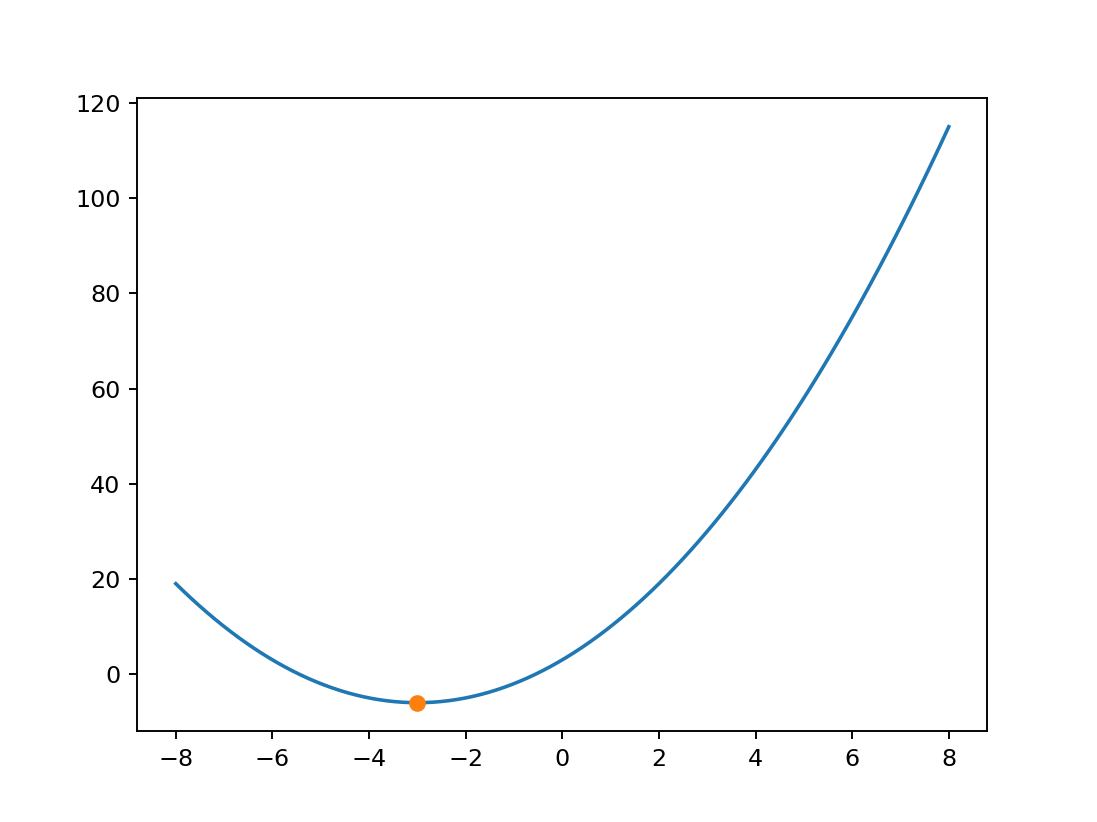

In [42]:
plt.plot(x_arr, get_y(1,2,3,4,x_arr));
plt.plot([get_x_argmax(1,2,3,4)], [get_y_max(1,2,3,4)], 'o' );

### How call the derived function with a correctly ordered set of parameters

In [43]:
get_y(*get_params(param_names, a=1,b=2,c=3,zeta=4)+(3,))

## IPWInterfact

In [44]:
from bmcs_utils.api import InteractiveModel, IPWInteract

Define a model class with trait attributes representing the
model parameters. The `trait.api` package provides the basic
types `Int`, `Float`, `Str`, `Array`, `List`, `Dict`

Define `subplots` method and `update_plot` method.

In [45]:
import traits.api as tr

class QuadEq(InteractiveModel):
    name='Quad'
    a = tr.Float(3, param=True, latex='a', minmax=(-8,8))
    b = tr.Float(3, param=True, latex='b', minmax=(-8,8))
    c = tr.Float(3, param=True, latex='c', minmax=(-8,8))
    zeta = tr.Float(3, param=True, latex=r'\zeta', minmax=(-8,8))
    param_names = ['a','b','c','zeta']

    def subplots(self, fig):
        return fig.subplots(1, 2)

    def update_plot(self, axes):
        ax, ax2 = axes
        params = self.get_params()
        x_arr = np.linspace(-8,8,50)
        y_arr = get_y(*params+(x_arr,))
        y_dx_arr = get_y_dx(*params+(x_arr,))
#        y_arr = get_y(self.a, self.b, self.c, self.zeta, x_arr)
        ax.plot([get_x_argmax(*params)], [get_y_max(*params)], 'o',
                color='red');
        ax.fill_between(x_arr, y_arr,0,alpha=0.8);
        ax2.plot(x_arr, y_dx_arr);
        ax2.fill_between(x_arr, y_dx_arr, 0, color='green', alpha=0.8);

<IPython.core.display.Javascript object>


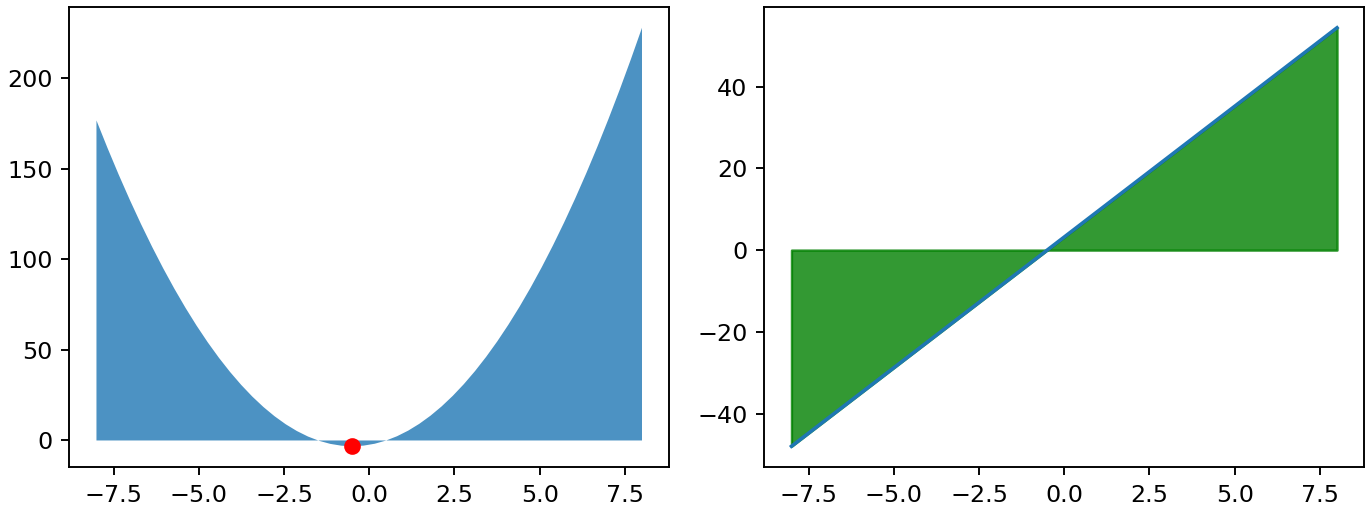

In [24]:
qei = IPWInteract([QuadEq(name='First quad',a=2), 
                   QuadEq(name='Another quad')],
                 figsize=(8,3))
qei.interact()